In [9]:
import os
import argparse
import torch
import torch.nn.functional
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt

from model import UNet
from data import HAM10000
from utils import normalize, iou_metric

from tqdm import tqdm

parser = argparse.ArgumentParser()

parser.add_argument("--gpu_num", default="0", type=str)
parser.add_argument("--interpolate", default="bicubic", type=str)

parser.add_argument("--image_dir", default="dataset/imgs", type=str)
parser.add_argument("--mask_dir", default="dataset/masks", type=str)

def plot(pred, y):
    fig = plt.figure()

    pred = pred.transpose((1, 2, 0))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(pred)
    ax1.set_title('Prediction')
    ax1.axis("off")
        
    y = y.transpose((1, 2, 0))
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(y)
    ax2.set_title('Answer')
    ax2.axis("off")
    plt.show()


def inference(args):
    ham = HAM10000(image_dir=args.image_dir, mask_dir=args.mask_dir, train=False)
    test_loader = DataLoader(
        ham, batch_size=1, shuffle=True, drop_last=True
    )

    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_num
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = UNet().to(device)
    model.load_state_dict(torch.load("model/best_model.pt", map_location=device))
    model.eval()

    best_iou = []
    average_iou = 0
    for X, y in tqdm(test_loader):
        X, y = normalize(X.to(device)), y.to(device)
        pred = model(X)
        pred = F.interpolate(pred, size=(450, 600), mode=args.interpolate)
        iou = iou_metric(pred, y)
        average_iou += iou
        pred = torch.argmax(pred, dim=1).detach().cpu().numpy()
        y = torch.argmax(y, dim=1).detach().cpu().numpy()
        best_iou.append((iou, pred, y))

    print(f"Average IoU: {average_iou / len(test_loader) :.4f}")
    return sorted(best_iou, reverse=True)[:5]
    

In [10]:
args = parser.parse_args("")
best_iou = inference(args)

100%|██████████| 2003/2003 [01:37<00:00, 20.50it/s]

Average IoU: 0.8524


IoU: 0.9824


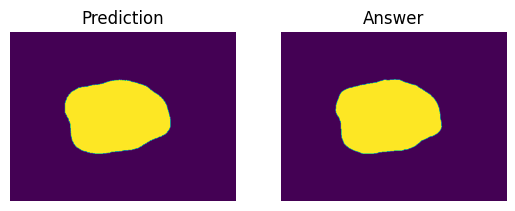

IoU: 0.9821


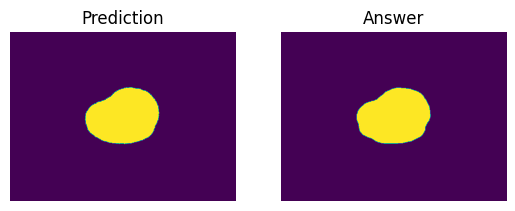

IoU: 0.9815


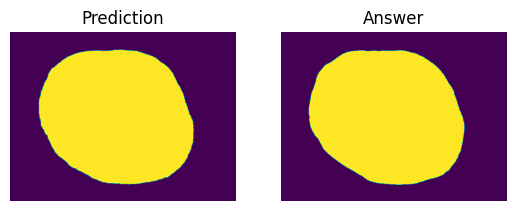

IoU: 0.9809


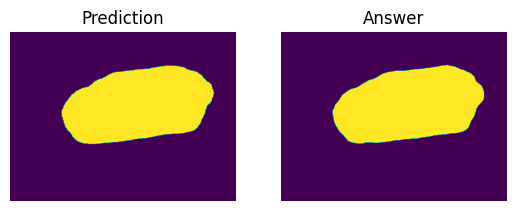

IoU: 0.9801


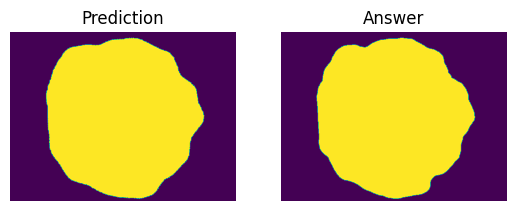

In [11]:
for iou, pred, y in best_iou:
    print(f'IoU: {iou:.4f}')
    plot(pred, y)